In [72]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil
from sklearn.cluster import KMeans
from sklearn.cluster import MeanShift
from sklearn.mixture import GaussianMixture
from sklearn.cluster import AffinityPropagation
from sklearn.cluster import DBSCAN
from sklearn.cluster import OPTICS

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'iris:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F19%2F420%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240507%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240507T165259Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D78b6aed4d035f52d2c0a18c7a6b414809fed5383d772ccf3931f0678a484965ea0230dfcd9018f2b405577c64ae931da06c7c49eac2bd216a7a3d8604ba5548b63167781db14a99663b6b20cc622caef9653a9fed04133b9edcca88a7a3f13f156b441c852ed4129a4922bcaf93e5f41156de522f7a328fdda82069cb9959db27b529a0a9b935b1d36e604cdd56edc8d6bdece2d47fa307a0a999fffd05e36dc3451ad1c203bc1bcb51504f00ed1bd2c3244911cefc663d25cccec99d45f55d0b8103270292b85e5e5449b6254066f25aebbcaf1b5896b38d2a86cf19b441eaba42fcb0adb0de6240cbbf3e6a06f4da1851f6f878add98ef0936df45575680fc'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 3687 bytes downloaded
Downloaded and uncompressed: iris
Data source import complete.


In [73]:
import numpy as np
import pandas as pd
#!pip install umap
!pip install umap-learn

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
sns.set_style("darkgrid")

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PowerTransformer

from sklearn.decomposition import PCA
import umap

from sklearn.cluster import KMeans

import random
import time

std_figure_size = (8,5)
plt.rc("axes", labelweight="bold", labelsize="large", titleweight="bold", titlesize=14, titlepad=10)

fixed_random_state = random.seed(42)
n_parallel_jobs = -1

%config IPCompleter.use_jedi=False

**Definiendo y leyendo el DATASET de IRIS**

In [74]:
df = pd.read_csv('/kaggle/input/iris/Iris.csv')

df.head()

,Id,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
0,1,5.1,3.5,1.4,0.2,Iris-setosa
1,2,4.9,3.0,1.4,0.2,Iris-setosa
2,3,4.7,3.2,1.3,0.2,Iris-setosa
3,4,4.6,3.1,1.5,0.2,Iris-setosa
4,5,5.0,3.6,1.4,0.2,Iris-setosa


**Revisando si hay filas repetidas**

In [75]:
n_dup = len(df) - len(df.drop_duplicates())

print(f"Number of duplicate rows: {n_dup}")

Number of duplicate rows: 0



**Revisando si existen valores nulos o vacios**

In [76]:
df.isnull().sum()

Id               0
SepalLengthCm    0
SepalWidthCm     0
PetalLengthCm    0
PetalWidthCm     0
Species          0
dtype: int64

**Revisar el tipo de datos que tenemos en el DATASET de IRIS, numero de filas y columnas, valores nulos por columnas**

In [77]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             150 non-null    int64  
 1   SepalLengthCm  150 non-null    float64
 2   SepalWidthCm   150 non-null    float64
 3   PetalLengthCm  150 non-null    float64
 4   PetalWidthCm   150 non-null    float64
 5   Species        150 non-null    object 
dtypes: float64(4), int64(1), object(1)
memory usage: 7.2+ KB


**Organizando y arreglando los nombres de las columnas: Se eliminan espacios en blanco y conversion de todas las palabras a minusculas**

In [78]:
cols_cleaned = []

for col in df.columns:
    cols_cleaned.append(col.strip().lower())

df.columns = cols_cleaned

# sanity check
df.head()

,id,sepallengthcm,sepalwidthcm,petallengthcm,petalwidthcm,species
0,1,5.1,3.5,1.4,0.2,Iris-setosa
1,2,4.9,3.0,1.4,0.2,Iris-setosa
2,3,4.7,3.2,1.3,0.2,Iris-setosa
3,4,4.6,3.1,1.5,0.2,Iris-setosa
4,5,5.0,3.6,1.4,0.2,Iris-setosa


**Resumen grafico de las distribuciones**


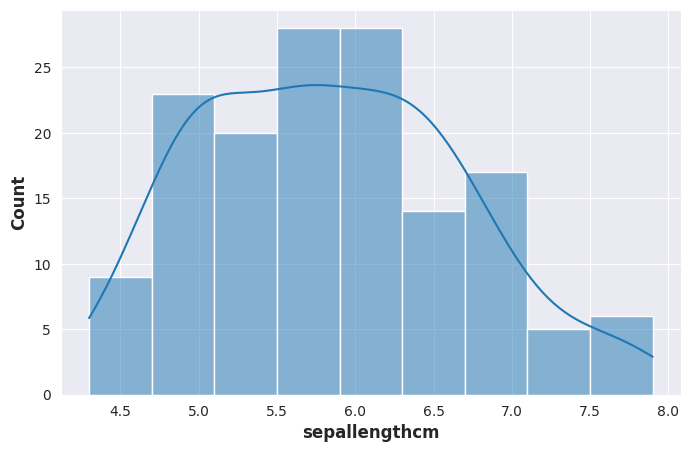

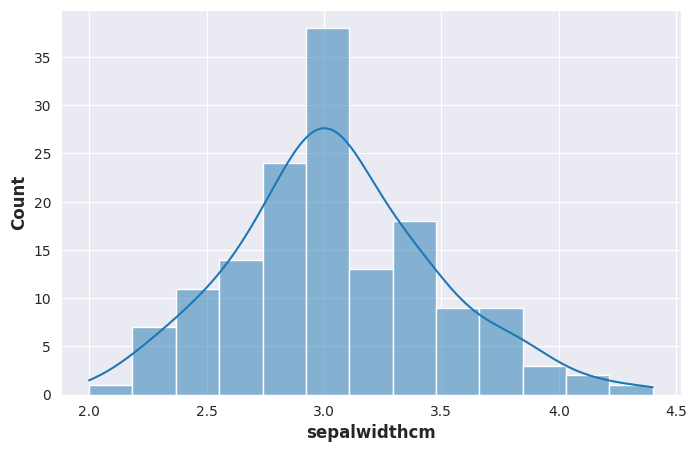

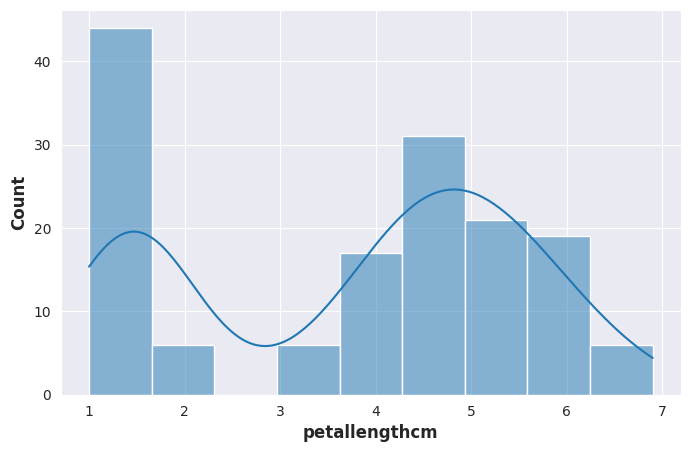

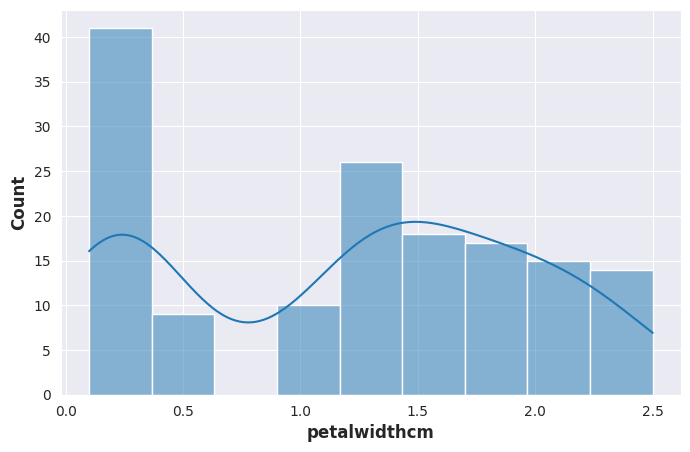

In [79]:
for col in df.select_dtypes(include=[np.number]).drop(columns=['id']):
    fig, axs = plt.subplots(figsize=std_figure_size)
    sns.histplot(data=df, x=col, kde=True, ax=axs)
    plt.show()

**Creamos un copia del dataset y lo llamamos X**

In [80]:
X = df.copy()

**Iniciamos el Clustering,**
Como mi dataset contiene datos que no son numericos(species), debo filtrarlos eso lo hago usando el metodo df.select_dtypes(include=[np.number]) y con el drop ignoro la columna id, esto me dara acceso solo a las columnas que tenga datos numericos y a las que no simplemente las ignora

In [81]:
X_valnum = df.select_dtypes(include=[np.number]).drop(columns=['id'])
X_tf = StandardScaler().fit_transform(X_valnum)

**El PowerTransformer es una técnica de preprocesamiento de datos que se utiliza para transformar variables numéricas en una distribución más gaussiana o normal.**
Es decir, la mayoría de los datos se concentran alrededor de la media, y la dispersión de los datos se puede describir en términos de desviación estándar

In [82]:
X_tf2 = PowerTransformer(standardize=False).fit_transform(X_tf)

**Asigno el nombre de mi nuevo DataFrame luego de aplicar la transformacion y columns=X_valnum.columns asigno el nombre de las columnas que tenia en el anterior dataframe**

In [83]:
X = pd.DataFrame(X_tf2, columns=X_valnum.columns)

X.head()

,sepallengthcm,sepalwidthcm,petallengthcm,petalwidthcm
0,-0.972914,0.963947,-1.121699,-1.219266
1,-1.254819,-0.126271,-1.121699,-1.219266
2,-1.543675,0.329035,-1.162766,-1.219266
3,-1.690529,0.105499,-1.080253,-1.219266
4,-1.112958,1.166559,-1.121699,-1.219266


**Intento 1: K-medias sin ninguna reducción de dimensionalidad previa**

**Hago un analisis para revisar cual el numero optimo de clusters a utilizar usando el algoritmo K-Means**

**La interpretación de la inercia es que cuanto menor sea su valor, más compactos y cohesionados son los clusters, lo que sugiere que los puntos dentro de cada cluster están más cerca unos de otros y que los clusters están mejor definidos.**

In [84]:
inertias_1 = []
range_clusters_1 = np.arange(2, 6, dtype=int)

for n in range_clusters_1:
    kmeans_1 = KMeans(n_clusters=n, random_state=fixed_random_state, n_init = 10).fit(X)
    inertia = kmeans_1.inertia_
    inertias_1.append(inertia)
    print(f"Inercia con {n} clusters: {inertia}")

Inercia con 2 clusters: 233.0677830889527
Inercia con 3 clusters: 145.152328722461
Inercia con 4 clusters: 114.31449944928072
Inercia con 5 clusters: 92.93255382489832


**Metodo del codo: Buscamos el punto donde la disminución de la inercia comienza a disminuir significativamente. Este punto se llama "elbow" (codo) y sugiere una disminución menos pronunciada en la inercia a partir de ese número de clusters.**

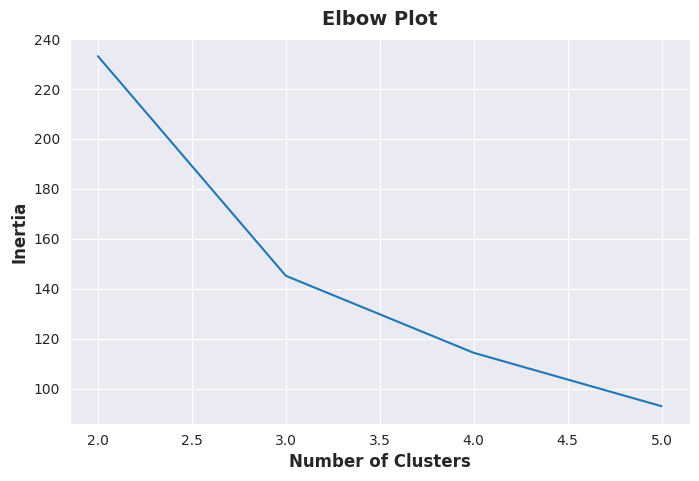

In [85]:
fig, axs = plt.subplots(figsize=std_figure_size)
sns.lineplot(x=range_clusters_1, y=inertias_1)
plt.title('Elbow Plot')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
# plt.ylim(bottom=0)
plt.show()

In [86]:
kmeans = KMeans(n_clusters=n, random_state=fixed_random_state, n_init=10).fit(X)
labels_1 = KMeans(n_clusters=3, n_init=10, random_state=fixed_random_state).fit_predict(X)

**Reducción a 2 dimensiones después de la agrupación para poder trazar los resultados**

Usamos a UMAP para poder bajar la dimesion a 2

In [87]:
reducer_1 = umap.UMAP(n_components=2, n_neighbors=15, n_jobs=-1, random_state=fixed_random_state)
embedding_1 = reducer_1.fit_transform(X)

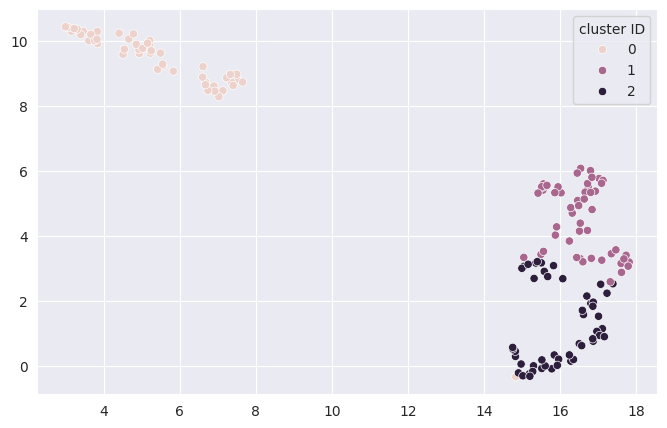

In [88]:
plt.figure(figsize=std_figure_size)
sns.scatterplot(x=embedding_1[:, 0], y=embedding_1[:, 1], hue=labels_1)
plt.legend(title="cluster ID")
plt.show()

**Intento 2: K-medias con reducción de dimensionalidad previa mediante PCA**



**Identificar el número "óptimo" de componentes (principales) que se deben mantener**

El numero de componentes que tendriamos seria 4 pero como lo que se busca en reducir al dimesionalidad con PCA elegimos 3.

In [89]:
pca_2 = PCA(n_components=3, random_state=fixed_random_state).fit(X)

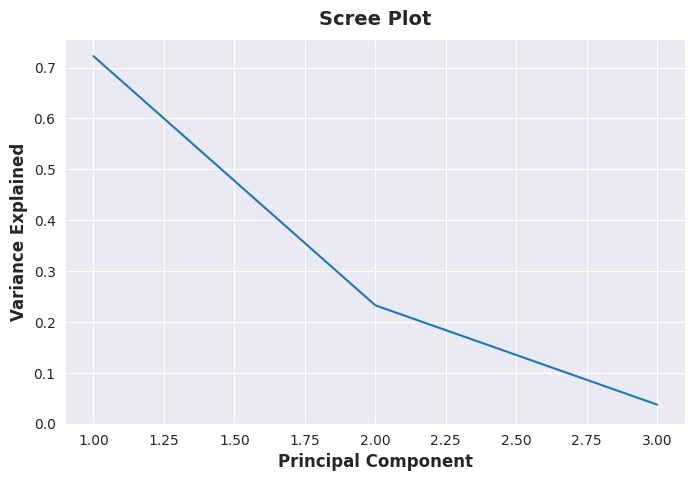

In [90]:
princ_comps_2 = np.arange(pca_2.n_components_, dtype=int) + 1

fig, axs = plt.subplots(figsize=std_figure_size)
sns.lineplot(x=princ_comps_2, y=pca_2.explained_variance_ratio_)
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.ylim(bottom=0)
plt.show()

**Reducción a 2 dimensiones**

In [91]:
X_red_2 = PCA(n_components=2, random_state=fixed_random_state).fit_transform(X)

In [92]:
X_red_2 = pd.DataFrame(X_red_2, columns=["pc1", "pc2"])

X_red_2.head()

,pc1,pc2
0,-2.175667,-0.566928
1,-2.070142,0.553957
2,-2.355274,0.214583
3,-2.333476,0.469105
4,-2.298122,-0.715052


**Identificación del número "óptimo" de clústeres**

In [93]:
inertias_2 = []
range_clusters_2 = np.arange(2, 6, dtype=int)

for n in range_clusters_2:
    kmeans_2 = KMeans(n_clusters=n, n_init = 10, random_state=fixed_random_state).fit(X_red_2)
    inertia2 = kmeans_2.inertia_
    inertias_2.append(inertia2)
    print(f"Inercia con {n} clusters: {inertia2}")

Inercia con 2 clusters: 206.69278885920255
Inercia con 3 clusters: 118.93899437842848
Inercia con 4 clusters: 88.58215191118029
Inercia con 5 clusters: 67.93054090680809


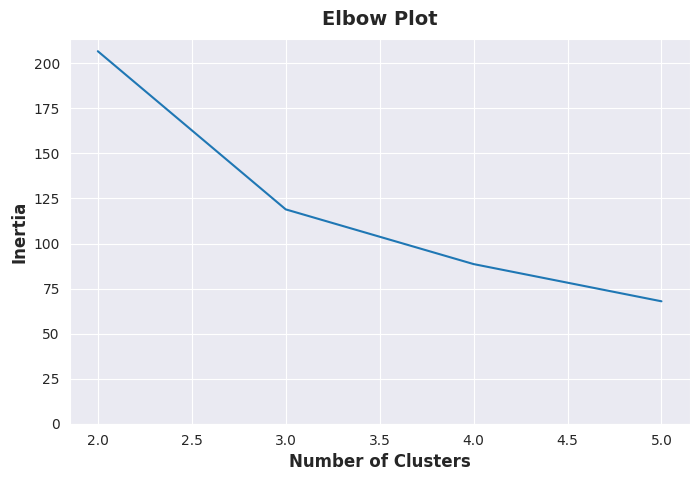

In [94]:
fig, axs = plt.subplots(figsize=std_figure_size)
sns.lineplot(x=range_clusters_2, y=inertias_2)
plt.title('Elbow Plot')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.ylim(bottom=0)
plt.show()

**Clustering en conjuntos de datos con dimensiones reducidas**

In [95]:
labels_2 = KMeans(n_clusters=3, n_init = 10, random_state=fixed_random_state).fit_predict(X_red_2)

**Reducción a 2 dimensiones *después* de la agrupación para poder trazar los resultados**

In [96]:
reducer_2 = umap.UMAP(n_components=2, n_neighbors=15, n_jobs=-1, random_state=fixed_random_state)
embedding_2 = reducer_2.fit_transform(X_red_2)

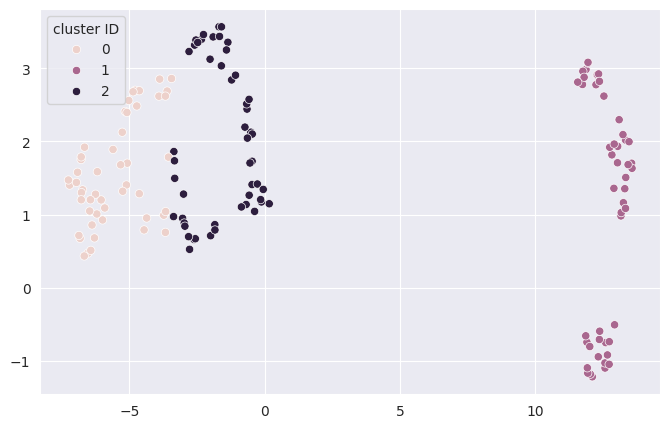

In [97]:
plt.figure(figsize=std_figure_size)
sns.scatterplot(x=embedding_2[:, 0], y=embedding_2[:, 1], hue=labels_2)
plt.legend(title="cluster ID")
plt.show()

**Intento 3: K-medias con reducción de dimensionalidad previa mediante UMAP**



**Reduction to 2 dimensions**

In [98]:
reducer_3 = umap.UMAP(n_components=2, n_neighbors=15, n_jobs=-1, random_state=fixed_random_state)
embedding_3 = reducer_3.fit_transform(X)

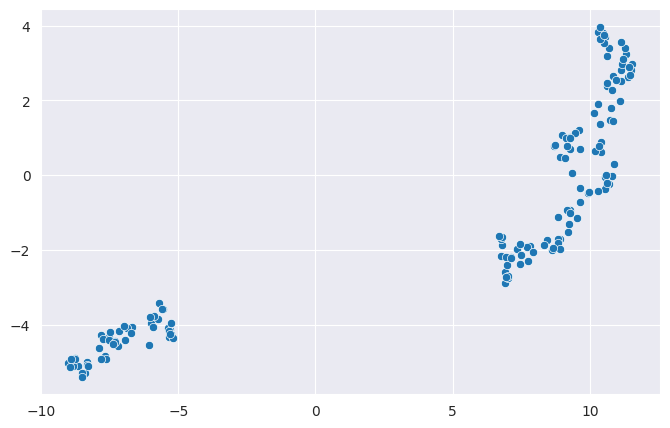

In [99]:
plt.figure(figsize=std_figure_size)
sns.scatterplot(x=embedding_3[:, 0], y=embedding_3[:, 1])
plt.show()

In [100]:
X_red_3 = pd.DataFrame(embedding_3, columns=["comp_1", "comp_2"])

# sanity check
X_red_3.head()

,comp_1,comp_2
0,-7.541337,-4.314363
1,-5.305155,-4.139064
2,-5.993881,-3.954957
3,-5.728802,-3.847707
4,-7.825038,-4.285521


**Identificar el número "óptimo" de clústeres**

In [101]:
inertias_3 = []
range_clusters_3 = np.arange(2, 6, dtype=int)

for n in range_clusters_3:
    kmeans_3 = KMeans(n_clusters=n, n_init = 10, random_state=fixed_random_state).fit(X_red_3)
    inertia3 = kmeans_3.inertia_
    inertias_3.append(kmeans_3.inertia_)
    print(f"Inercia con {n} clusters: {inertia3}")

Inercia con 2 clusters: 725.242919921875
Inercia con 3 clusters: 288.5802307128906
Inercia con 4 clusters: 171.1264190673828
Inercia con 5 clusters: 105.87777709960938


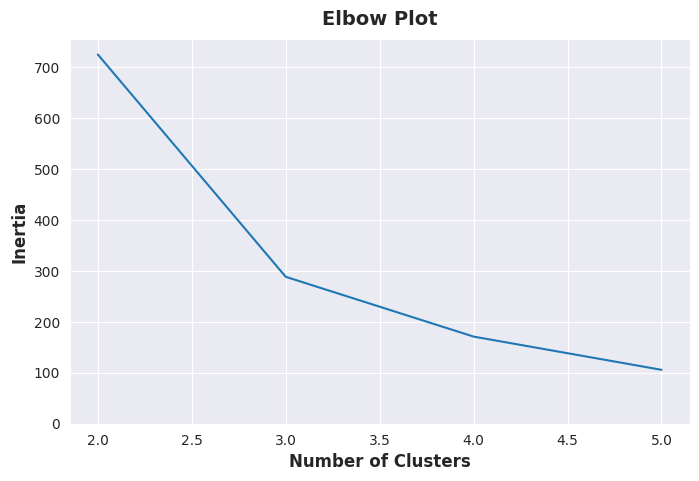

In [102]:
fig, axs = plt.subplots(figsize=std_figure_size)
sns.lineplot(x=range_clusters_3, y=inertias_3)
plt.title('Elbow Plot')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.ylim(bottom=0)
plt.show()

**Clustering en conjuntos de datos con dimensiones reducidas**

In [103]:
labels_3 = KMeans(n_clusters=3, n_init = 10, random_state=fixed_random_state).fit_predict(X_red_3)

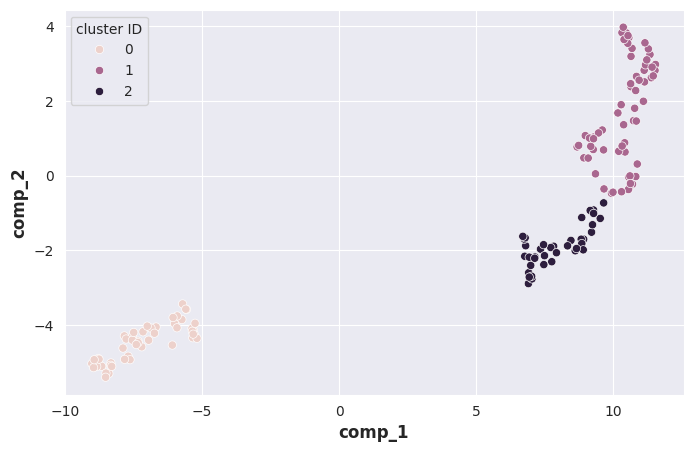

In [104]:
plt.figure(figsize=std_figure_size)
sns.scatterplot(data=X_red_3, x="comp_1", y="comp_2", hue=labels_3)
plt.legend(title="cluster ID")
plt.show()

**Comparación de los diferentes enfoques**

Vuelva a trazar los grupos identificados por cada enfoque uno al lado del otro para mayor comodidad

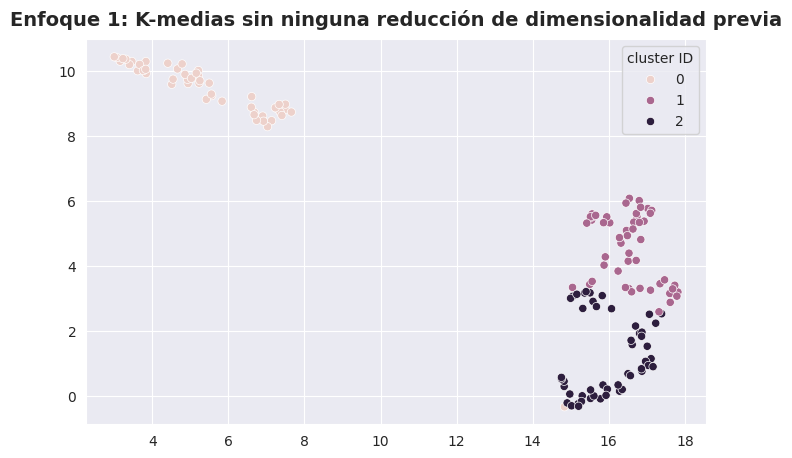

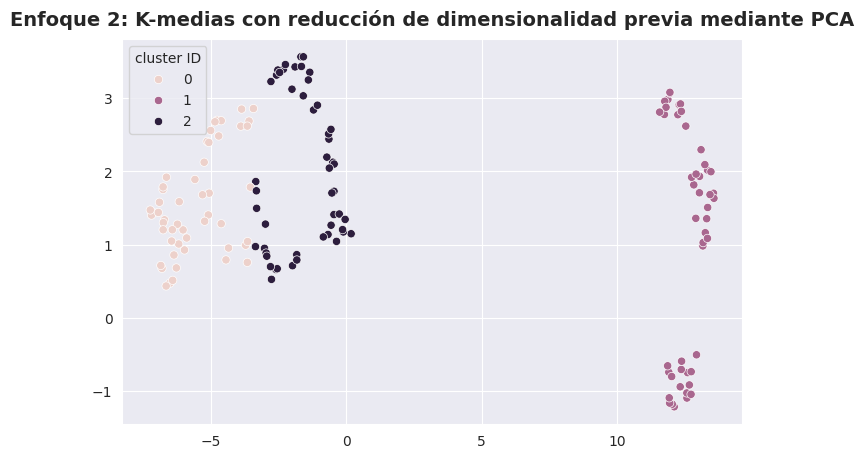

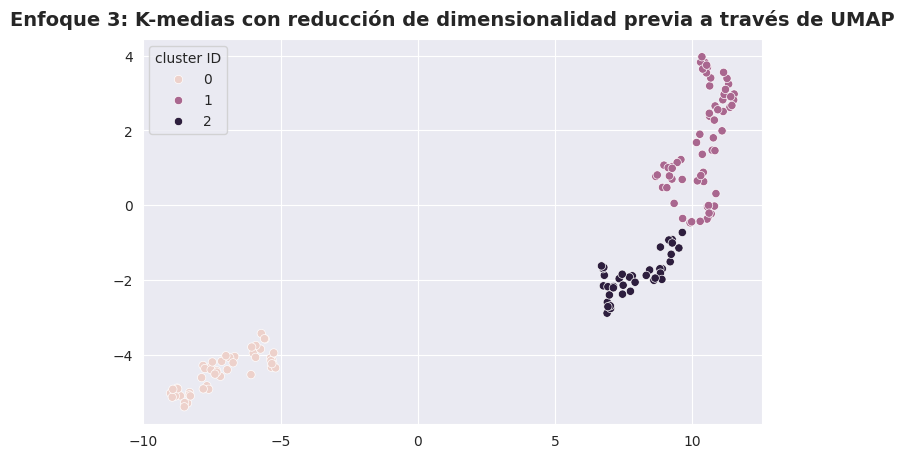

In [105]:
plt.figure(figsize=std_figure_size)
sns.scatterplot(x=embedding_1[:, 0], y=embedding_1[:, 1], hue=labels_1)
plt.title("Enfoque 1: K-medias sin ninguna reducción de dimensionalidad previa")
plt.legend(title="cluster ID")
plt.show()

plt.figure(figsize=std_figure_size)
sns.scatterplot(x=embedding_2[:, 0], y=embedding_2[:, 1], hue=labels_2)
plt.title("Enfoque 2: K-medias con reducción de dimensionalidad previa mediante PCA")
plt.legend(title="cluster ID")
plt.show()

plt.figure(figsize=std_figure_size)
sns.scatterplot(data=X_red_3, x="comp_1", y="comp_2", hue=labels_3)
plt.title("Enfoque 3: K-medias con reducción de dimensionalidad previa a través de UMAP")
plt.xlabel(None)
plt.ylabel(None)
plt.legend(title="cluster ID")
plt.show()

**Comparación de los gráficos de codo para cada búsqueda de "número óptimo de conglomerados" uno al lado del otro**
**Como recordatorio, la métrica de inercia de k-means no está normalizada.**

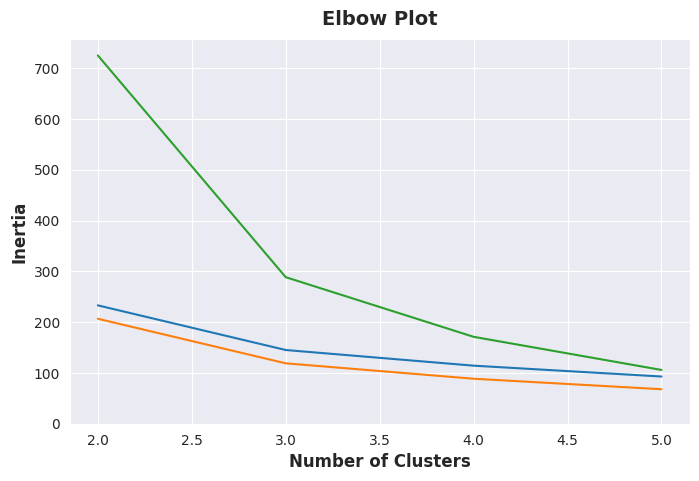

In [106]:
fig, axs = plt.subplots(figsize=std_figure_size)
sns.lineplot(x=range_clusters_1, y=inertias_1)
sns.lineplot(x=range_clusters_2, y=inertias_2)
sns.lineplot(x=range_clusters_3, y=inertias_3)
plt.title('Elbow Plot')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.ylim(bottom=0)
plt.show()

**Intercambiar los ID de los grupos para que los resultados de los 3 enfoques sean directamente comparables**

**Tomando como referencia los ID de etiqueta generados por el "enfoque 1". **

In [107]:
def corr_labels_2(elem):
    if elem == 1:
        return 2
    elif elem == 2:
        return 1
    else:
        return elem


labels_2 = pd.Series(labels_2).apply(corr_labels_2)

In [108]:
def corr_labels_3(elem):
    if elem == 1:
        return 0
    elif elem == 0:
        return 1
    else:
        return elem


labels_3 = pd.Series(labels_3).apply(corr_labels_3)

**Comparación lado a lado de las distribuciones de características para cada grupo en los 3 enfoques**

**N.B.: Tenga en cuenta que cada enfoque puede "ordenar" los ID de los grupos de manera diferente, lo que significa que el ID 0 para el enfoque 1 puede ser el mismo que el ID 2 para el enfoque 2 y el ID 1 para el enfoque 3. Como hay bastante Debido a la aleatoriedad de esto, tuve que renunciar a "reorganizar manualmente" los resultados para que fuera más fácil realizar comparaciones cruzadas directas.**

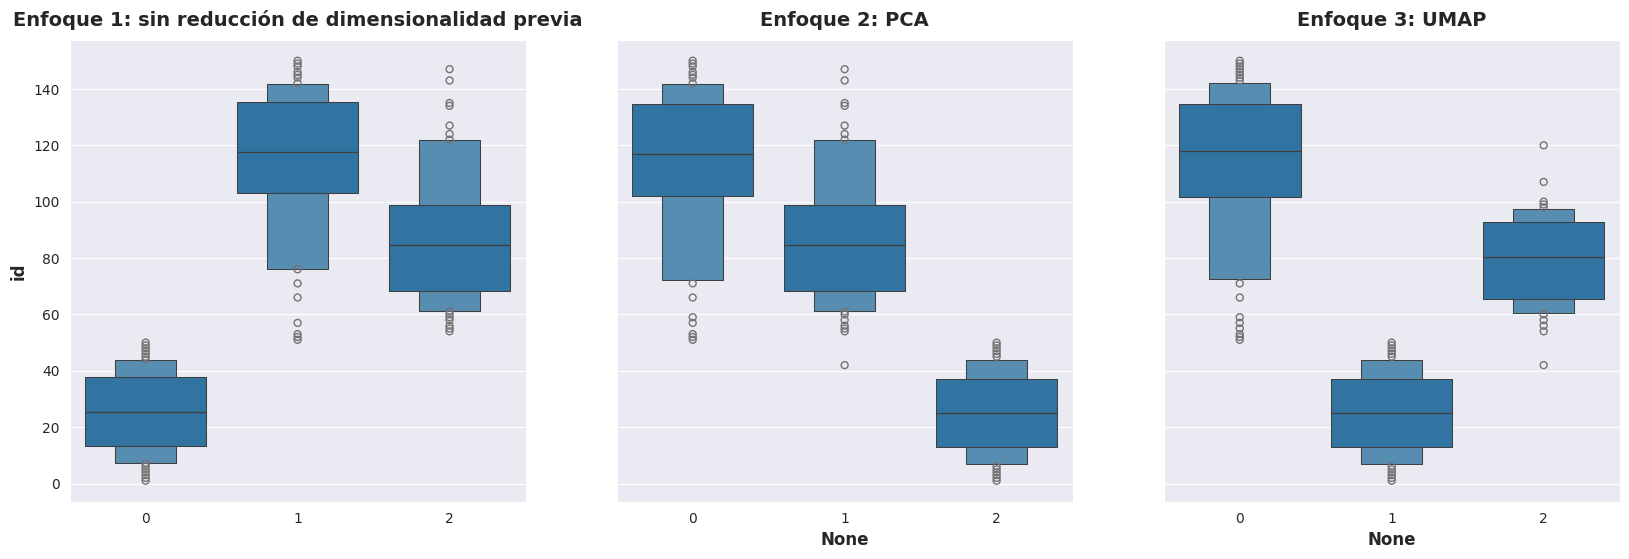

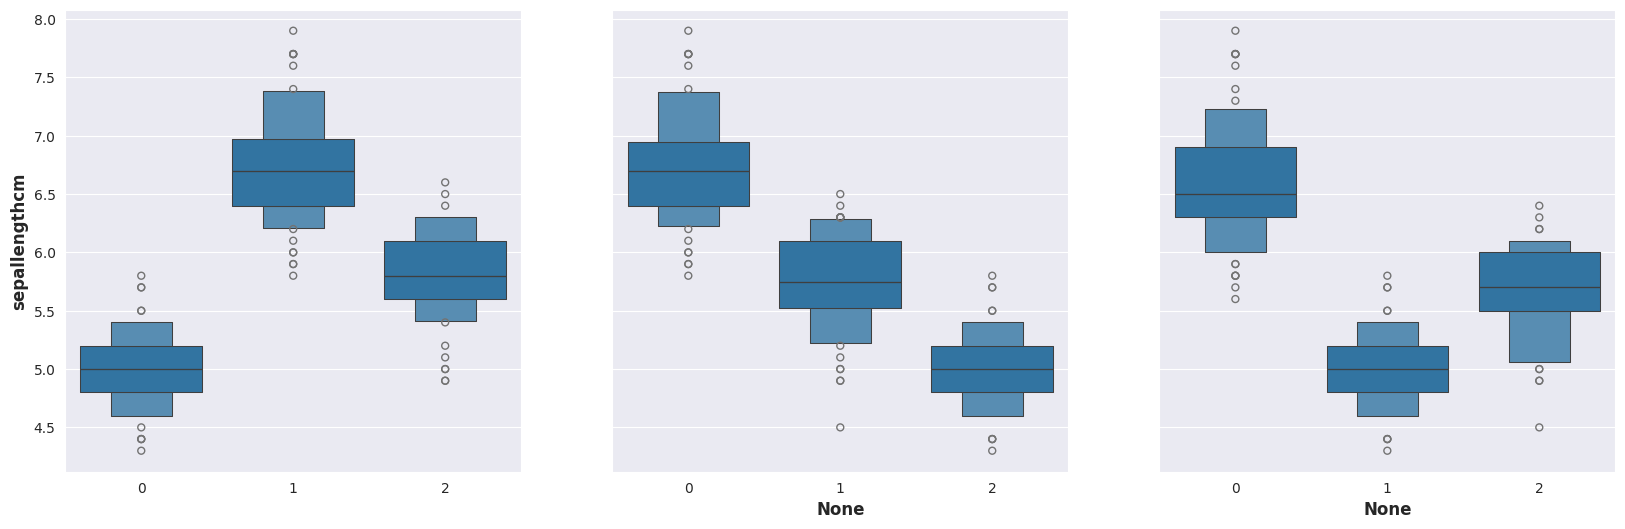

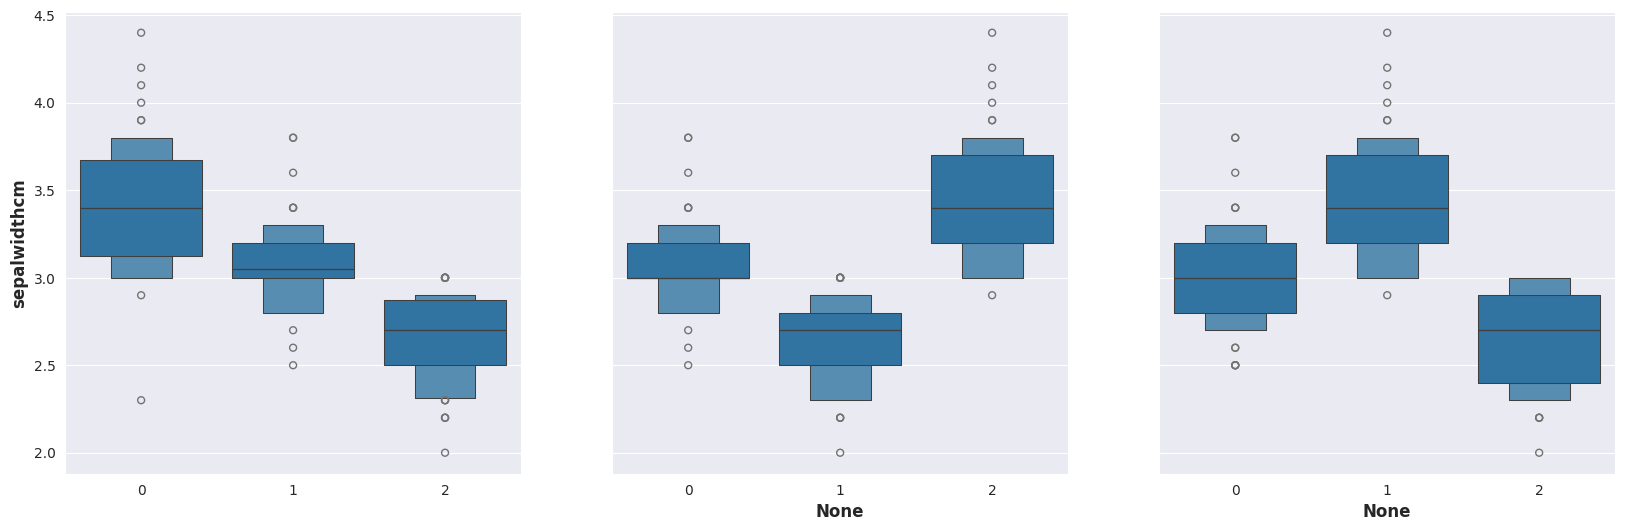

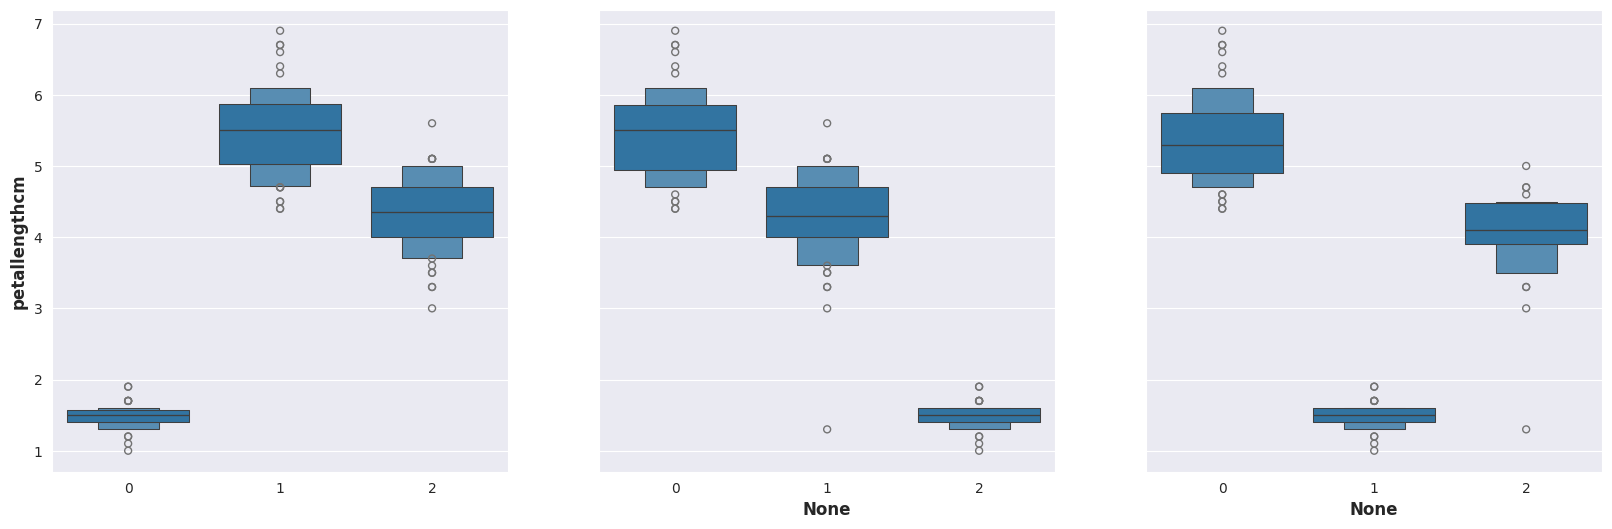

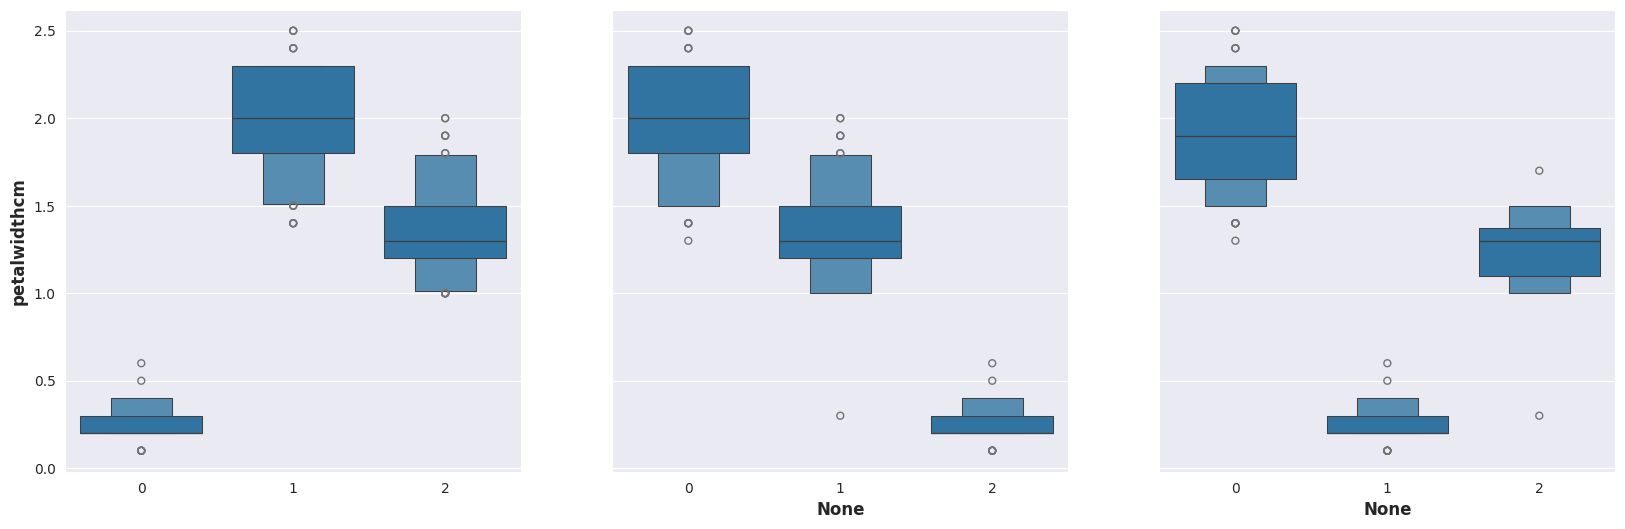

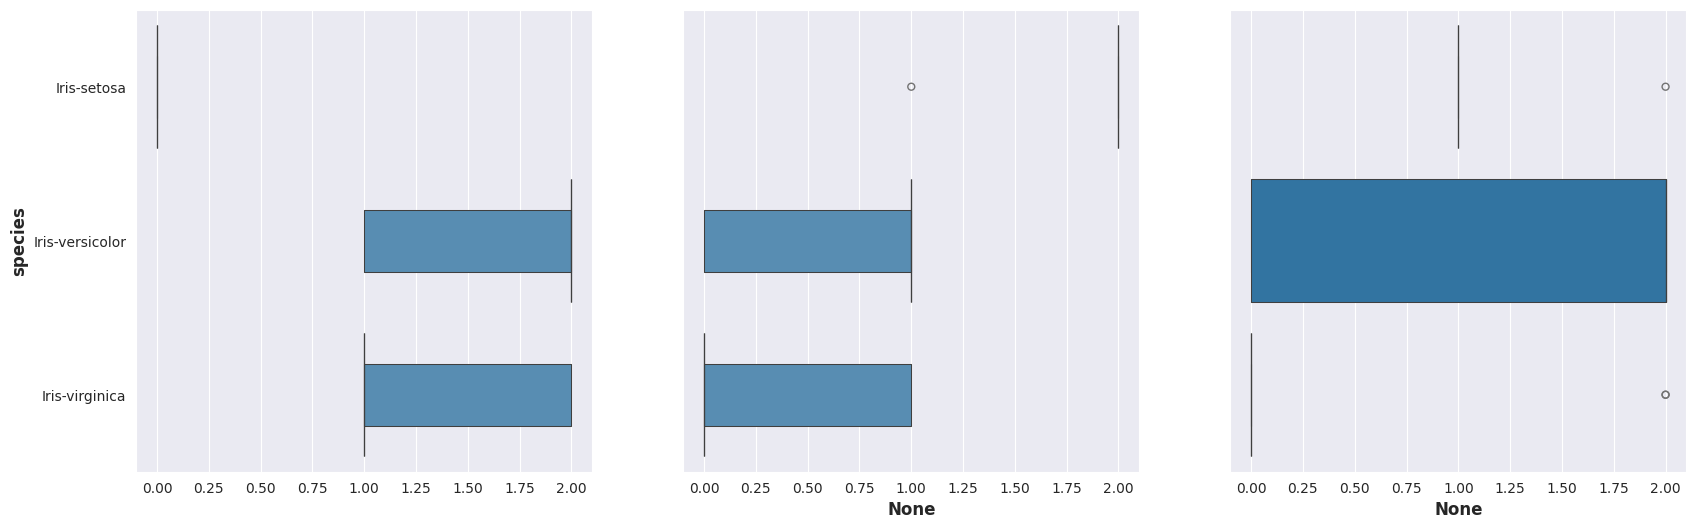

In [109]:
for i, col in enumerate(df.columns):
    fig, axs = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(20,6))
    sns.boxenplot(x=labels_1, y=df[col], ax=axs[0])
    sns.boxenplot(x=labels_2, y=df[col], ax=axs[1])
    sns.boxenplot(x=labels_3, y=df[col], ax=axs[2])
    if i == 0:
        axs[0].set_title("Enfoque 1: sin reducción de dimensionalidad previa")
        axs[1].set_title("Enfoque 2: PCA")
        axs[2].set_title("Enfoque 3: UMAP")
    plt.show()

**¿Cuántos puntos de datos hay en cada cluster para cada enfoque?**

In [110]:
counts_1 = pd.Series(labels_1).value_counts().sort_index()
counts_2 = pd.Series(labels_2).value_counts().sort_index()
counts_3 = pd.Series(labels_3).value_counts().sort_index()

cluster_counts = pd.DataFrame({"app_1": counts_1, "app_2": counts_2, "app_3": counts_3})

cluster_counts.index.name = "cluster_id"

cluster_counts

,app_1,app_2,app_3
cluster_id,,,
0,50,51,63
1,50,50,49
2,50,49,38
